In [67]:
import numpy as np
import pandas as pd
from pathlib import Path

In [68]:
car_data = pd.read_csv(r"C:\Users\mab03\Desktop\ML-Zoomcamp\01-intro\car_fuel_efficiency.csv")
car_data.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

In [69]:
car_data_use = car_data[['engine_displacement', 'horsepower', 'vehicle_weight','model_year', 'fuel_efficiency_mpg']]
car_data_use.head(5)

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


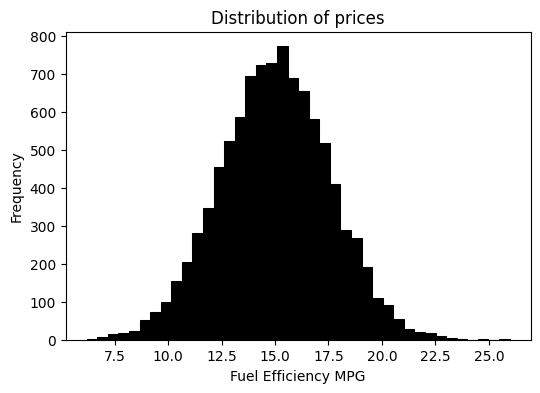

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

sns.histplot(car_data_use.fuel_efficiency_mpg, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Fuel Efficiency MPG')
plt.title('Distribution of prices')

plt.show()

Fuel Efficiency does not have a long tail so no need for Log transformation

In [71]:
car_data_use.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [72]:
car_data_use.horsepower.median()

np.float64(149.0)

In [73]:
# Shuffle the dataset
np.random.seed(42)

n = len(car_data_use)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = car_data_use.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [74]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [75]:
print(f"Training: {len(df_train)} | Validation {len(df_val)} | Testing: {len(df_test)}")

Training: 5824 | Validation 1940 | Testing: 1940


In [76]:
# FIll missing values on Nan

# Calculate the Mean from the training set only
train_mean = df_train.horsepower.mean()

# Option 1: Fill with 0
def fill_with_0(df):
    filled_df = df.copy()
    filled_hp = df.horsepower.fillna(0)
    filled_df.horsepower = filled_hp
    return filled_df
    
# Option 2: FIll with mean (Training Set only)
def fill_with_mean(df, mean):
    filled_df = df.copy()
    filled_hp = df.horsepower.fillna(mean)
    filled_df.horsepower = filled_hp
    return filled_df

def prepare_X(df,fill: str = 'mean'):
    if fill == 'zero':
        df_train = fill_with_0(df)
    elif fill == 'mean':
        df_train = fill_with_mean(df,train_mean)
    X = df_train.values    
    
    return X

X_train_w_0 = prepare_X(df_train, 'zero')
X_train_w_mean = prepare_X(df_train, 'mean')

In [77]:
X_train_w_0[:5]

array([[ 220.        ,  144.        , 2535.88759124, 2009.        ],
       [ 160.        ,  141.        , 2741.17048439, 2019.        ],
       [ 230.        ,  155.        , 2471.88023726, 2017.        ],
       [ 150.        ,  206.        , 3748.16446858, 2015.        ],
       [ 300.        ,  111.        , 2135.71635893, 2006.        ]])

In [78]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [79]:
# Prepare Validation and fill with 0
X_val_w_0 = prepare_X(df_val, 'zero')
# Train the data filled with 0
w_0, w = train_linear_regression(X_train_w_0, y_train)
y_pred = w_0 + X_val_w_0.dot(w)
print(f"Validation RMSE (Filled with 0): {round(rmse(y_val, y_pred),2)}")

Validation RMSE (Filled with 0): 0.52


In [80]:
# Train the data filled with mean
X_val_w_mean = prepare_X(df_val, 'mean')
# Train the data filled with mean
w_0, w = train_linear_regression(X_train_w_mean, y_train)
y_pred = w_0 + X_val_w_mean.dot(w)
print(f"Validation RMSE (Filled with mean): {round(rmse(y_val, y_pred),2)}")

Validation RMSE (Filled with mean): 0.46


In [81]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [83]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train_w_0, y_train, r=r)
    y_pred = w_0 + X_val_w_0.dot(w)
    # print(f"Validation RMSE (Filled with 0): {round(rmse(y_val, y_pred),2)}")
    print(f"Validation RMSE (Filled with 0): {rmse(y_val, y_pred)} | Rounded: {round(rmse(y_val, y_pred),2)}")
    
    # print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[1], w[2]))

Validation RMSE (Filled with 0): 0.5173782638841185 | Rounded: 0.52
Validation RMSE (Filled with 0): 0.5173314578308275 | Rounded: 0.52
Validation RMSE (Filled with 0): 0.5171115525775559 | Rounded: 0.52
Validation RMSE (Filled with 0): 0.5187525130701629 | Rounded: 0.52
Validation RMSE (Filled with 0): 0.5222348802092528 | Rounded: 0.52
Validation RMSE (Filled with 0): 0.5229812979636569 | Rounded: 0.52


In [87]:
all_rmses = []
# Shuffle the data with different seeds
for seed in range(10):
    np.random.seed(seed)

    n = len(car_data_use)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = car_data_use.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']
    
    # Fill Na's with zeros
    X_train_w_0 = prepare_X(df_train, 'zero')
    
    # Prepare Validation and fill with 0
    X_val_w_0 = prepare_X(df_val, 'zero')
    # Train the data filled with 0
    w_0, w = train_linear_regression(X_train_w_0, y_train)
    y_pred = w_0 + X_val_w_0.dot(w)
    print(f"Validation RMSE (Filled with 0): {rmse(y_val, y_pred)}")
    
    all_rmses.append(rmse(y_val, y_pred))
    
# Calculate RMSE Standard deviation
rmse_std = np.std(all_rmses)
print(f"RMSE std = {rmse_std} | RMSE std rounded = {round(rmse_std,3)}")

Validation RMSE (Filled with 0): 0.5206531296297207
Validation RMSE (Filled with 0): 0.5213388912866506
Validation RMSE (Filled with 0): 0.5228069974913666
Validation RMSE (Filled with 0): 0.5159516741255491
Validation RMSE (Filled with 0): 0.5109129460116937
Validation RMSE (Filled with 0): 0.5283406460212935
Validation RMSE (Filled with 0): 0.5313910658190373
Validation RMSE (Filled with 0): 0.509067038739038
Validation RMSE (Filled with 0): 0.5147399129482789
Validation RMSE (Filled with 0): 0.513186590829269
RMSE std = 0.006989446427824928 | RMSE std rounded = 0.007


In [90]:
# Combine train and validation sets
# First shuffle the data with seed = 9
np.random.seed(9)

n = len(car_data_use)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = car_data_use.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

print(len(df_train))
print(len(y_train))
# combine traine and validation sets
df_train = pd.concat([df_train,df_val])
y_train = np.concatenate([y_train,y_val])
print(len(df_train))
print(len(y_train))


5824
5824
7764
7764


In [92]:
# Fill missing values with 0
X_train_w_0 = prepare_X(df_train, 'zero')
# Prepare Test and fill with 0
X_val_w_0 = prepare_X(df_test, 'zero')
# Train the data filled with 0
w_0, w = train_linear_regression_reg(X_train_w_0, y_train,r=0.001)
y_pred = w_0 + X_val_w_0.dot(w)
print(f"Test RMSE (Filled with 0): {rmse(y_test, y_pred)}")

Test RMSE (Filled with 0): 0.5156261299185628
